In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import os
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt

import pyfrac
from pyfrac.utils.sofiutils import *
from pyfrac.utils.modellingutils import *
from pyfrac.hydrafrac.acquisition import recgeom

In [2]:
# 3 layer model - USER DEFINED
expname = 'StySamp'
outpath = '../../FDModelling/StylolitesSample/'

# Rock Properties - subsurface models

In [3]:
xlim = 0.2  # 20cm
ylim = 0.1  # 10cm
zlim = 0.1  # 10cm
nbounds = 30
# time params (in seconds!)
dt = 5e-8
tdur = 0.0005

In [4]:
dx = dy = dz = 0.002  # 5mm

nx = int(xlim/dx) + (nbounds*2)
ny = int(ylim/dy) + (nbounds*2)
nz = int(zlim/dz) + (nbounds*2)

# Subsurface properties
vp = 5260  # m/s
vs = 3260  # m/s
rho = 2590;  # kg/m3
 
print(nx,ny,nz)

160 110 110


In [5]:
# MAKE MODELS
mod_vp = vp * np.ones([nx, ny, nz])
mod_vs = vs * np.ones([nx, ny, nz])
mod_rho = rho * np.ones([nx, ny, nz])

In [6]:
# mod_vp[:,90,:] =  vp*1.5
# mod_vp[:,75,:] =  vp*1.5
# mod_vp[:,65,:] =  vp*1.5
# fig,ax = plt.subplots(1,1,figsize=[5,5])
# c = ax.imshow(mod_vp[nbounds:-nbounds,nbounds:-nbounds,0].T, cmap='copper_r')
# c = ax.imshow(mod_vp[0,nbounds:-nbounds,nbounds:-nbounds].T, cmap='copper_r')

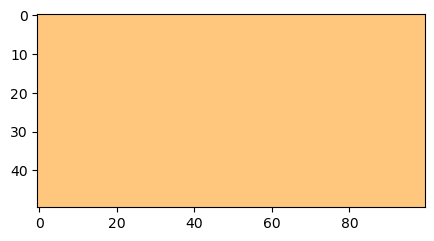

In [14]:
print(mod_vp.shape)
fig,ax = plt.subplots(1,1,figsize=[5,5])
c = ax.imshow(mod_vp[nbounds:-nbounds,nbounds:-nbounds,0].T, cmap='copper_r')
# c = ax.imshow(mod_vp[0,nbounds:-nbounds,nbounds:-nbounds].T, cmap='copper_r')

In [8]:
# Write as binary
os.makedirs(os.path.join(outpath,'inputs/model/'), exist_ok=True)
np.transpose(mod_vp,[0,2,1]).astype(np.float32).tofile(os.path.join(outpath,'inputs/model/%s.vp'%expname))#,format='<f')
np.transpose(mod_vs,[0,2,1]).astype(np.float32).tofile(os.path.join(outpath,'inputs/model/%s.vs'%expname))  #,format='<f')
np.transpose(mod_rho,[0,2,1]).astype(np.float32).tofile(os.path.join(outpath,'inputs/model/%s.rho'%expname))  #,format='<f')

# Acquisition Geometry - Receivers & Source

In [9]:
# RECEIVERS
recA = np.array([50, 50, 0])/1000
recB = np.array([100, 50, 0])/1000
recC = np.array([150, 50, 0])/1000

recD = np.array([50, 50, 100])/1000
recE = np.array([150, 50, 100])/1000

recF = np.array([200, 50, 50])/1000
recG = np.array([0, 50, 50])/1000

recH = np.array([50, 0, 50])/1000
recI = np.array([100, 0, 50])/1000
recJ = np.array([150, 0, 50])/1000

recK = np.array([50, 100, 50])/1000
recL = np.array([100, 100, 50])/1000
recM = np.array([150, 100, 50])/1000



recs=np.vstack([recA,recB,recC,recD,
                recE,recF,recG,recH,
                recI,recJ,recK,recL, 
                recM
               ])

# shift x & y for abs boundaries
recs[:,0] += (nbounds*dx)
recs[:,1] += (nbounds*dy)
recs[:,2] += (nbounds*dz)

rec_xzy = np.vstack([recs.T[0],recs.T[2],recs.T[1]]).T
print(rec_xzy)
np.savetxt(os.path.join(outpath,'inputs/receiver.dat'),
           rec_xzy.astype(np.float32), 
           fmt='%.4f')

[[0.11 0.06 0.11]
 [0.16 0.06 0.11]
 [0.21 0.06 0.11]
 [0.11 0.16 0.11]
 [0.21 0.16 0.11]
 [0.26 0.11 0.11]
 [0.06 0.11 0.11]
 [0.11 0.11 0.06]
 [0.16 0.11 0.06]
 [0.21 0.11 0.06]
 [0.11 0.11 0.16]
 [0.16 0.11 0.16]
 [0.21 0.11 0.16]]


In [10]:
# Source 
sx, sy, sz = 0.1, 0.05, 0.05
sx += (nbounds*dx)
sy += (nbounds*dy)
sz += (nbounds*dz)

sx, sz, sy = recs[0]

td = dt*5  # ignition time 5 timesteps in
fc = 100000  # central frequency
amp = 1.  # amplitude
string_list = [str(i) for i in [sx, sz, sy, td, fc, amp]]
src_string = '\t'.join(string_list)
print(src_string)

text_file = open(os.path.join(outpath,'inputs/sources.dat'), "wt")
text_file.writelines(src_string)
text_file.close()

0.11	0.11	0.06	2.5e-07	100000	1.0


# BUILD JSON FOR SOFI

In [11]:
# mod params
n_xzy = mod_rho.transpose(0,2,1).shape
d_xzy = [dx, dz, dy]


tsnap_params = [dt, 2000*dt, dt*5]
smgrm_ndt = 100

SOFIjsonfilename = os.path.join(outpath,'SOFI3D_%s.json'%expname)

sofimaster = '~/Documents/Projects/MicroseismicModelling/SOFI3D-master/bin/'
num_procs = 8
sofi_param_file = "SOFI3D_%s.json"%expname
shellfilename = os.path.join(outpath,'runSOFI3D_%s.sh'%expname)


In [12]:
# GET THE DIFFERENT STRINGS - this will be updated in the future
default_strs = get_default_strings()

monitor_strs = get_monitor_str(tsnap_params, smgrm_ndt, expname, sbsmp_xyz=1)
t_str = get_time_str(dt, tdur)
mod_strs = get_subsurfmod_str(n_xzy, d_xzy,expname)
bndry_str = get_boundary_str(fs=False, npad=nbounds, cpml=True)
src_str = get_source_str()

write_SOFIjsonParams = write_SOFIjsonParams(default_strs, 
                                            monitor_strs,  
                                            t_str, 
                                            mod_strs, 
                                            src_str, 
                                            bndry_str, 
                                            SOFIjsonfilename)
runscript = write_SOFIrunScript(sofimaster, 
                                num_procs, 
                                sofi_param_file, 
                                shellfilename)

In [13]:
mod_rho.transpose(0,2,1).shape

(160, 110, 110)